In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

DATA_PATH = "../mp4_to_bt656/church.mp4"
GLOBAL_SEED = 0

In [25]:
def calculate_detail_entropy(image, raw=False, ycrcb=False):
    if ycrcb:
        image = cv2.cvtColor(image, cv2.COLOR_YCrCb2BGR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) != 2 else image
    if not raw:
        DX = np.diff(image, axis=1)
        DY = np.diff(image, axis=0)

        hist_dx = cv2.calcHist([DX], [0], None, [256], [0, 256])
        hist_dx = hist_dx[hist_dx > 0]
        hist_dx /= DX.size

        hist_dy = cv2.calcHist([DY], [0], None, [256], [0, 256])
        hist_dy = hist_dy[hist_dy > 0]
        hist_dy /= DY.size

        return (-np.sum(hist_dx * np.log2(hist_dx)) + -np.sum(hist_dy * np.log2(hist_dy))) / 2
    else:
        hist = cv2.calcHist([image], [0], None, [256], [0, 256])
        hist = hist[hist > 0]
        hist /= image.size
        return -np.sum(hist * np.log2(hist))


def line_shuffling(image, block_size):
    if GLOBAL_SEED != None:
        np.random.seed(GLOBAL_SEED)
    image = np.array(image)
    height, width, _ = image.shape
    lines = [image[i * block_size:(i + 1) * block_size, :] for i in range(height // block_size)]
    np.random.shuffle(lines)
    scrambled_image = np.vstack(lines)
    return scrambled_image


def get_closest_shuffled_line(reference_line, frame, visited):
    distances = []
    for i, el in enumerate(frame):
        if i not in visited:
            distances.append(np.sum(np.abs(reference_line - el)))
        else:
            distances.append(np.inf)
    closest_line = np.argmin(distances)
    visited.add(closest_line)
    return frame[closest_line]


def break_line_shuffling(frame, cvt_color=True):
    if cvt_color:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2YCrCb).astype(int)
    visited = set()
    visited.add(0)
    reference_line = frame[0]
    visited_order = [reference_line]

    while len(visited) != len(frame):
        reference_line = get_closest_shuffled_line(reference_line, frame, visited)
        visited_order.append(reference_line)

    descrambled_image = np.array(visited_order)
    descrambled_image = descrambled_image.astype(np.uint8)
    if cvt_color:
        descrambled_image = cv2.cvtColor(descrambled_image, cv2.COLOR_YCrCb2BGR)
    return descrambled_image


def line_inversion(image, block_size):
    if GLOBAL_SEED != None:
        np.random.seed(GLOBAL_SEED)
    image = np.array(image)
    height, width, _ = image.shape
    lines = np.array([image[i * block_size:(i + 1) * block_size, :] for i in range(height // block_size)])
    flips = np.random.choice([0, 1], size=(len(lines),))
    for i, flip in enumerate(flips):
        if flip:
            lines[i] = 255 - lines[i]
    scrambled_image = np.vstack(lines)
    return scrambled_image


def attack_line_inversion(frame, cvt_color=True):
    if cvt_color:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2YCrCb).astype(int)
    reference_line = frame[0]
    unrolled_frame = [reference_line]
    for i in range(len(frame)):
        line = frame[i]
        distances = [np.sum(np.abs(reference_line - line)),
                     np.sum(np.abs(reference_line - (255 - line)))]

        if distances[0] < distances[1]:
            line = line
        else:
            line = 255 - line

        unrolled_frame.append(line)
        reference_line = line

    unrolled_frame = np.array(unrolled_frame).astype(np.uint8)
    if cvt_color:
        unrolled_frame = cv2.cvtColor(unrolled_frame, cv2.COLOR_YCrCb2BGR)
    return unrolled_frame


def line_rotation(image, block_size):
    if GLOBAL_SEED != None:
        np.random.seed(GLOBAL_SEED)
    image = np.array(image)
    height, width, _ = image.shape
    lines = np.array([image[i * block_size:(i + 1) * block_size, :] for i in range(height // block_size)])
    rotations = np.random.randint(0, len(image[0]), size=(len(lines),))
    for i, rotation in enumerate(rotations):
        if rotation:
            lines[i] = np.roll(lines[i], rotation, axis=1)
    scrambled_image = np.vstack(lines)
    return scrambled_image


def get_closest_rotation(reference_line, line):
    distances = []
    rolled_line = line
    for j in range(0, len(line), 1):
        # distances.append(np.linalg.norm(reference_line - rolled_line))
        distances.append(np.sum(np.abs(reference_line - rolled_line)))
        rolled_line = np.roll(rolled_line, 1, axis=0)
    optimal_roll = np.argmin(distances)
    line = np.roll(line, optimal_roll * 1, axis=0)
    return line


def break_line_rotator(frame, cvt_color=True):
    if cvt_color:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2YCrCb).astype(int)
    reference_line = frame[0]
    unrolled_frame = [reference_line]
    for i in range(len(frame)):
        line = frame[i]

        reference_line = get_closest_rotation(reference_line, line)
        unrolled_frame.append(reference_line)
    unrolled_frame = np.array(unrolled_frame).astype(np.uint8)
    if cvt_color:
        unrolled_frame = cv2.cvtColor(unrolled_frame, cv2.COLOR_YCrCb2BGR)
    return unrolled_frame

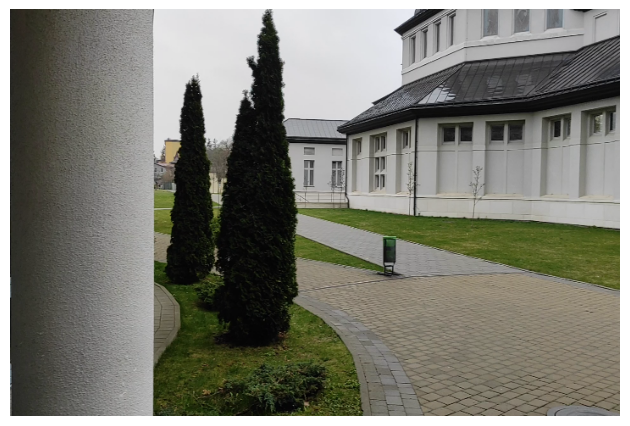

In [20]:
# read the first frame from video
cap = cv2.VideoCapture(DATA_PATH)
ret, frame = cap.read()
cap.release()
frame = cv2.resize(frame, (720, 480), cv2.INTER_AREA)

plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.tight_layout()
plt.show()

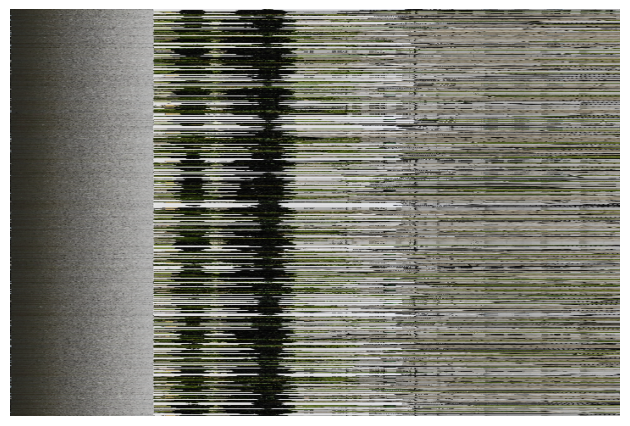

In [26]:

# Scramble the image
block_size = 1
line_shuffled= line_shuffling(frame, block_size)
plt.imshow(cv2.cvtColor(line_shuffled, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.tight_layout()
plt.show()

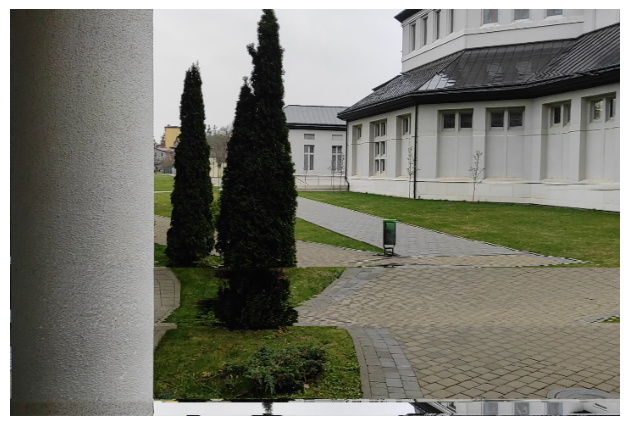

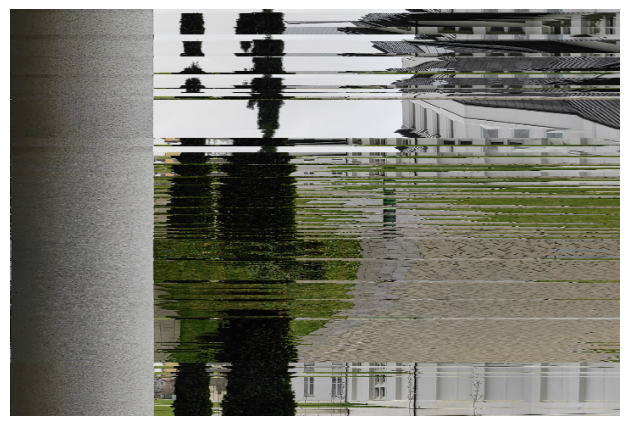

In [28]:
line_shuffled_broken = cv2.cvtColor(break_line_shuffling(line_shuffled), cv2.COLOR_BGR2RGB)
line_shuffled_broken_rgb = cv2.cvtColor(break_line_shuffling(line_shuffled, cvt_color=False), cv2.COLOR_BGR2RGB)
plt.imshow(line_shuffled_broken)
plt.axis('off')
plt.tight_layout()
plt.show()
plt.imshow(line_shuffled_broken_rgb)
plt.axis('off')
plt.tight_layout()
plt.show()

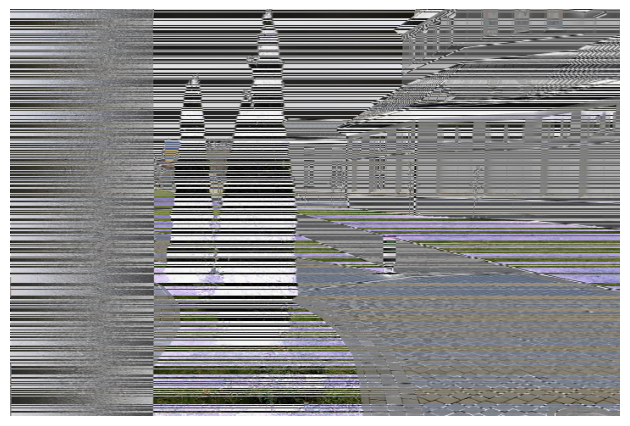

In [29]:
# Scramble the image
block_size = 1
line_inverted = line_inversion(frame, block_size)
plt.imshow(cv2.cvtColor(line_inverted, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.tight_layout()
plt.show()


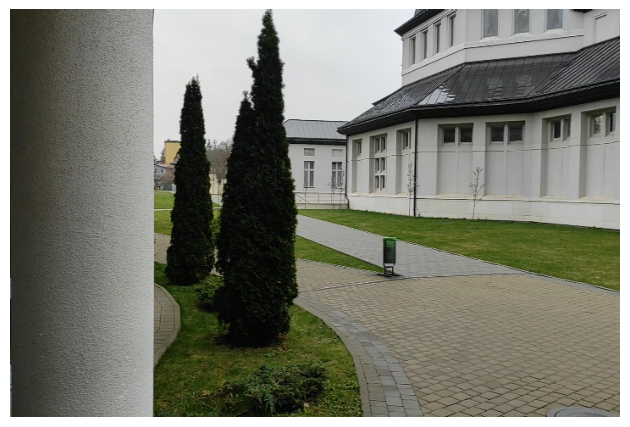

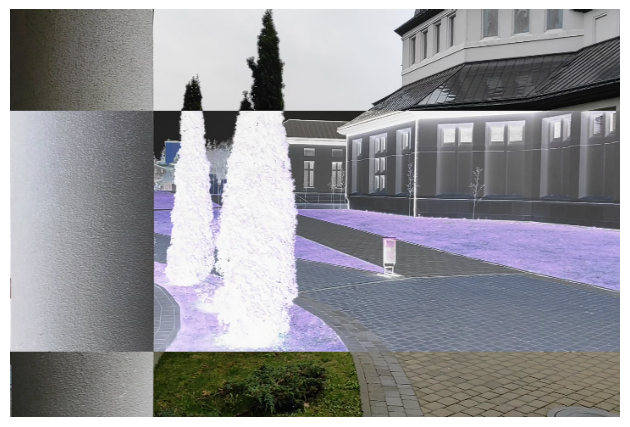

In [30]:
line_inverted_broken = cv2.cvtColor(attack_line_inversion(line_inverted), cv2.COLOR_BGR2RGB)
line_inverted_broken_rgb = cv2.cvtColor(attack_line_inversion(line_inverted, cvt_color=False), cv2.COLOR_BGR2RGB)
plt.imshow(line_inverted_broken)
plt.axis('off')
plt.tight_layout()
plt.show()
plt.imshow(line_inverted_broken_rgb)
plt.axis('off')
plt.tight_layout()
plt.show()


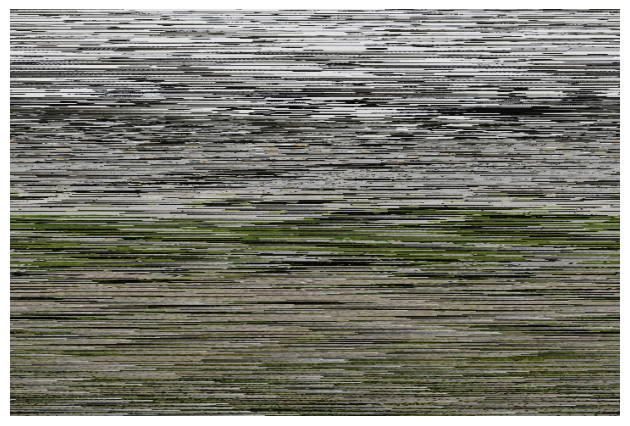

In [31]:
# Scramble the image
block_size = 1
line_rotated = line_rotation(frame, block_size)
plt.imshow(cv2.cvtColor(line_rotated, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.tight_layout()
plt.show()

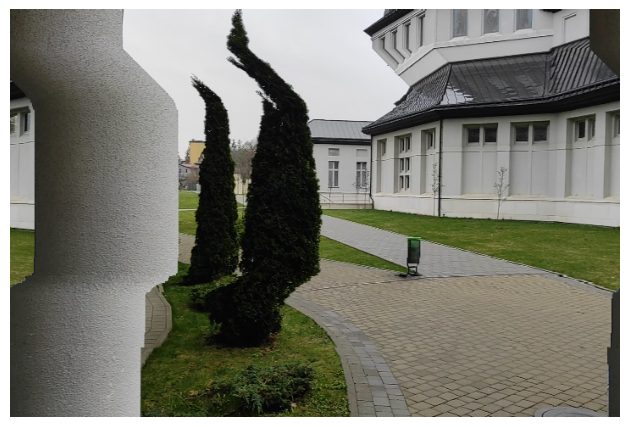

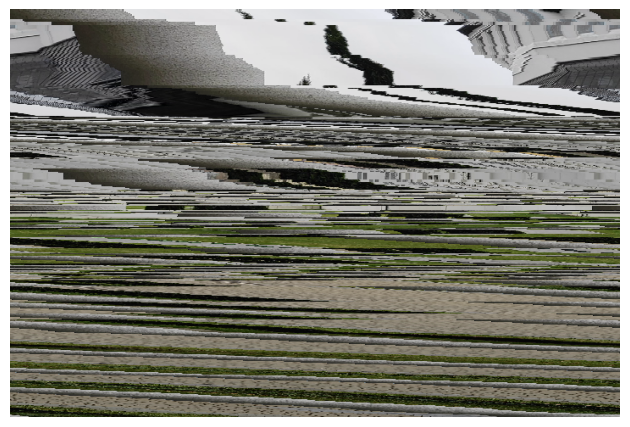

In [32]:
line_rotated_broken = cv2.cvtColor(break_line_rotator(line_rotated), cv2.COLOR_BGR2RGB)
line_rotated_broken_rgb = cv2.cvtColor(break_line_rotator(line_rotated, cvt_color=False), cv2.COLOR_BGR2RGB)
plt.imshow(line_rotated_broken)
plt.axis('off')
plt.tight_layout()
plt.show()
plt.imshow(line_rotated_broken_rgb)
plt.axis('off')
plt.tight_layout()
plt.show()

# Combining all results in fairly strong algorithm

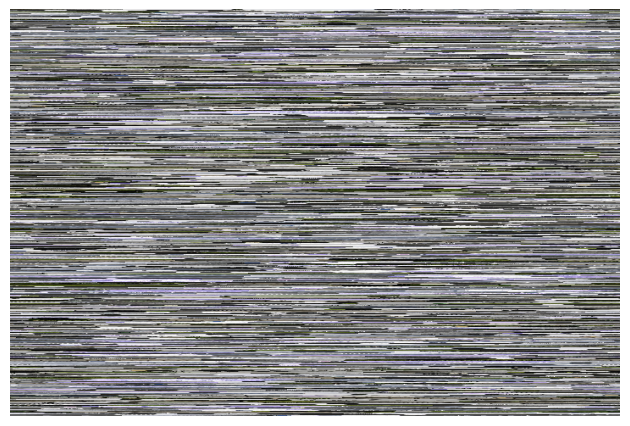

In [34]:
block_size = 1
combined = line_inversion(line_rotation(line_shuffling(frame, block_size), block_size), block_size)
plt.imshow(cv2.cvtColor(combined, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.tight_layout()
plt.show()

In [47]:

original_entropy = calculate_detail_entropy(frame)
# calculate entropy for each image
line_shuffled_entropy = calculate_detail_entropy(line_shuffled)
line_inverted_entropy = calculate_detail_entropy(line_inverted)
line_rotated_entropy = calculate_detail_entropy(line_rotated)
combined_entropy = calculate_detail_entropy(combined)
line_shuffled_broken_entropy = calculate_detail_entropy(line_shuffled_broken)
line_inverted_broken_entropy = calculate_detail_entropy(line_inverted_broken)
line_rotated_broken_entropy = calculate_detail_entropy(line_rotated_broken)
# rgb
line_shuffled_broken_rgb_entropy = calculate_detail_entropy(line_shuffled_broken_rgb)
line_inverted_broken_rgb_entropy = calculate_detail_entropy(line_inverted_broken_rgb)
line_rotated_broken_rgb_entropy = calculate_detail_entropy(line_rotated_broken_rgb)
# format up two decimal places
original_entropy = "{:.2f}".format(original_entropy)
line_shuffled_entropy = "{:.2f}".format(line_shuffled_entropy)
line_inverted_entropy = "{:.2f}".format(line_inverted_entropy)
line_rotated_entropy = "{:.2f}".format(line_rotated_entropy)
combined_entropy = "{:.2f}".format(combined_entropy)
line_shuffled_broken_entropy = "{:.2f}".format(line_shuffled_broken_entropy)
line_inverted_broken_entropy = "{:.2f}".format(line_inverted_broken_entropy)
line_rotated_broken_entropy = "{:.2f}".format(line_rotated_broken_entropy)
line_shuffled_broken_rgb_entropy = "{:.2f}".format(line_shuffled_broken_rgb_entropy)
line_inverted_broken_rgb_entropy = "{:.2f}".format(line_inverted_broken_rgb_entropy)
line_rotated_broken_rgb_entropy = "{:.2f}".format(line_rotated_broken_rgb_entropy)
# print results
print("Original entropy: ", original_entropy)
print("Line shuffled entropy: ", line_shuffled_entropy)
print("Line inverted entropy: ", line_inverted_entropy)
print("Line rotated entropy: ", line_rotated_entropy)
print("Line shuffled broken ycrcb entropy: ", line_shuffled_broken_entropy)
print("Line inverted broken ycrcb entropy: ", line_inverted_broken_entropy)
print("Line rotated broken ycrcb entropy: ", line_rotated_broken_entropy)
print("Line shuffled broken rgb entropy", line_shuffled_broken_rgb_entropy)
print("Line inverted broken rgb entropy", line_inverted_broken_rgb_entropy)
print("Line rotated broken rgb entropy", line_rotated_broken_rgb_entropy)
print("Combined entropy: ", combined_entropy)



Original entropy:  5.30
Line shuffled entropy:  6.32
Line inverted entropy:  6.13
Line rotated entropy:  6.47
Line shuffled broken ycrcb entropy:  5.33
Line inverted broken ycrcb entropy:  5.31
Line rotated broken ycrcb entropy:  5.30
Line shuffled broken rgb entropy 5.62
Line inverted broken rgb entropy 5.30
Line rotated broken rgb entropy 5.96
Combined entropy:  6.52


In [41]:
save_path = "./scrambling_algorithms/"

In [44]:
# save images; rgb images have rgb in name; ycrcb images (not present in variable name) have ycrcb in name; save in png format; convert all to bgr
cv2.imwrite(save_path + "line_shuffled.png", line_shuffled)
cv2.imwrite(save_path + "line_inverted.png", line_inverted)
cv2.imwrite(save_path + "line_rotated.png", line_rotated)
cv2.imwrite(save_path + "combined.png", cv2.cvtColor(combined, cv2.COLOR_RGB2BGR))
cv2.imwrite(save_path + "line_shuffled_broken_ycrcb.png", cv2.cvtColor(line_shuffled_broken, cv2.COLOR_RGB2BGR))
cv2.imwrite(save_path + "line_inverted_broken_ycrcb.png", cv2.cvtColor(line_inverted_broken, cv2.COLOR_RGB2BGR))
cv2.imwrite(save_path + "line_rotated_broken_ycrcb.png", cv2.cvtColor(line_rotated_broken, cv2.COLOR_RGB2BGR))
cv2.imwrite(save_path + "line_shuffled_broken_rgb.png", cv2.cvtColor(line_shuffled_broken_rgb, cv2.COLOR_RGB2BGR))
cv2.imwrite(save_path + "line_inverted_broken_rgb.png", cv2.cvtColor(line_inverted_broken_rgb, cv2.COLOR_RGB2BGR))
cv2.imwrite(save_path + "line_rotated_broken_rgb.png", cv2.cvtColor(line_rotated_broken_rgb, cv2.COLOR_RGB2BGR))






True

In [51]:
encrypted_image_other_line_inv = cv2.imread("sezam-a.png")

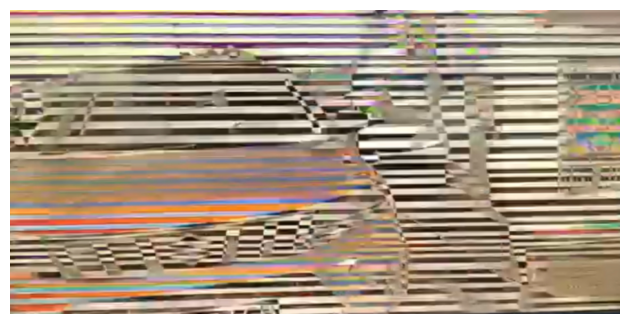

In [56]:
# bad perspective, does not work
encrypted_image_other_line_inv_att = attack_line_inversion(encrypted_image_other_line_inv)
plt.imshow(encrypted_image_other_line_inv_att)
plt.axis('off')
plt.tight_layout()
plt.show()